In [237]:
import numpy as np
import matplotlib.pyplot as plt

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

# Demonstrating Focus-diverse Phase Retrieval with Algorithmic Differentiation

This notebook walks through the use of `poi` (which is written in `prysm`) to perform focus-diverse phase retrieval. This was partially the result of a Visiting Technologist Experience at W.M. Keck Observatory working with the AO Development Team. The API is by no means finalized, but this notebook serves as a tutorial with which we can get started.

We begin by defining our instrument parameters that define the phase retrieval problem. They are stored in the Instrument Configuration dictionary `IC` below

In [238]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 4.87, # um
    'pupil_diameter' : 10950, # mm
    'focal_length' : 338492, # mm
    'wavelength' : 0.94, # um
}
SEGMENTED_PUPIL = False

The segmented pupil flag lets us employ a Keck-like pupil. However for simplicity we can start with a circular aperture.

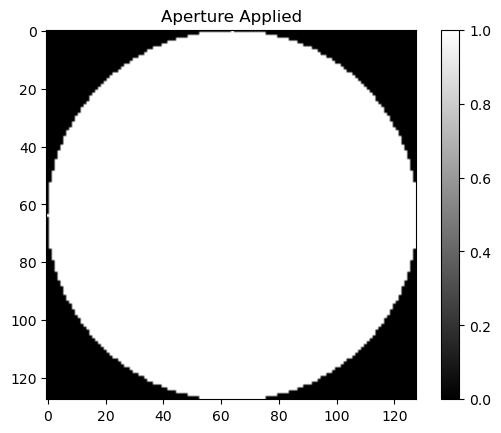

In [239]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

if SEGMENTED_PUPIL:
    # make a keck-like pupil
    cha = CompositeHexagonalAperture(x, y, 3, 1.32e3, 0.007e3, exclude=(0,))

    # set up spiders
    m1 = spider(1, .1e3, x, y, rotation=-120)
    m2 = spider(1, .1e3, x, y, rotation=-60)
    m3 = spider(1, .1e3, x, y, rotation=90)
    spider_ = m1&m2&m3
    A = cha.amp & spider_

else:
    A = circle(epd / 2, r)

plt.figure()
plt.title('Aperture Applied')
plt.imshow(A, cmap='gray')
plt.colorbar()
plt.show()

Next we want to define the modes that we want to optimize over. We choose the Zernike polynomials due to their orthogonality and composition of optical aberrations, but this choice is not critical. You may use your own preferred modes if you desire, and `prysm` supports many polynomials. Here we generate a random string of modal coefficients and sum them to get the resultant phase error in microns.

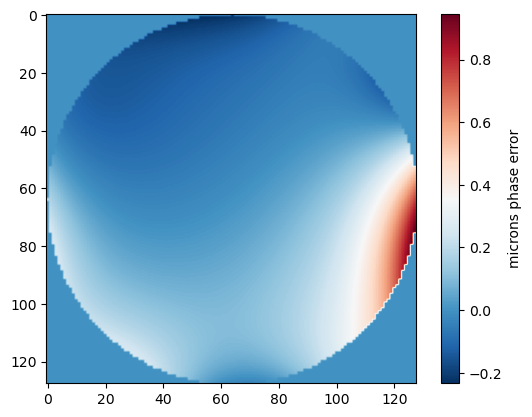

In [240]:
# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 37)]
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]

# Start with some random coefficients
coefs = np.random.random(len(nms))
phs = sum_of_2d_modes(basis_norm, coefs) * 1/5

plt.figure()
plt.imshow(phs * A, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

The next step is to create our simulated defocus data. The propagation macro below will create psfs given some amount of defocus in waves.

In [241]:
# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT.focus_fixed_sampling AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = A * np.exp(1j * k * phs)

def prop_to_focus(wavefunction, defocus_waves=0):

    # configure the defocus polynomial
    focus_polynomial = hopkins(0, 2, 0, r_z, t, 0) * defocus_waves
    defocus_aberration = A * np.exp(-1j * 2 * np.pi * focus_polynomial)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=128)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1)
psf2 = prop_to_focus(wf, defocus_waves=2)
psf3 = prop_to_focus(wf, defocus_waves=3)

Next, we plot the PSFs. The scaling factor on the modal coefficients we defined earlier was chosen arbitrarily, but aims to make sure the PSF is not aberrated outside of the capture range of the algorithm. We see here that we were succesful because a majority of the energy of the PSF is captured in the plotted array.

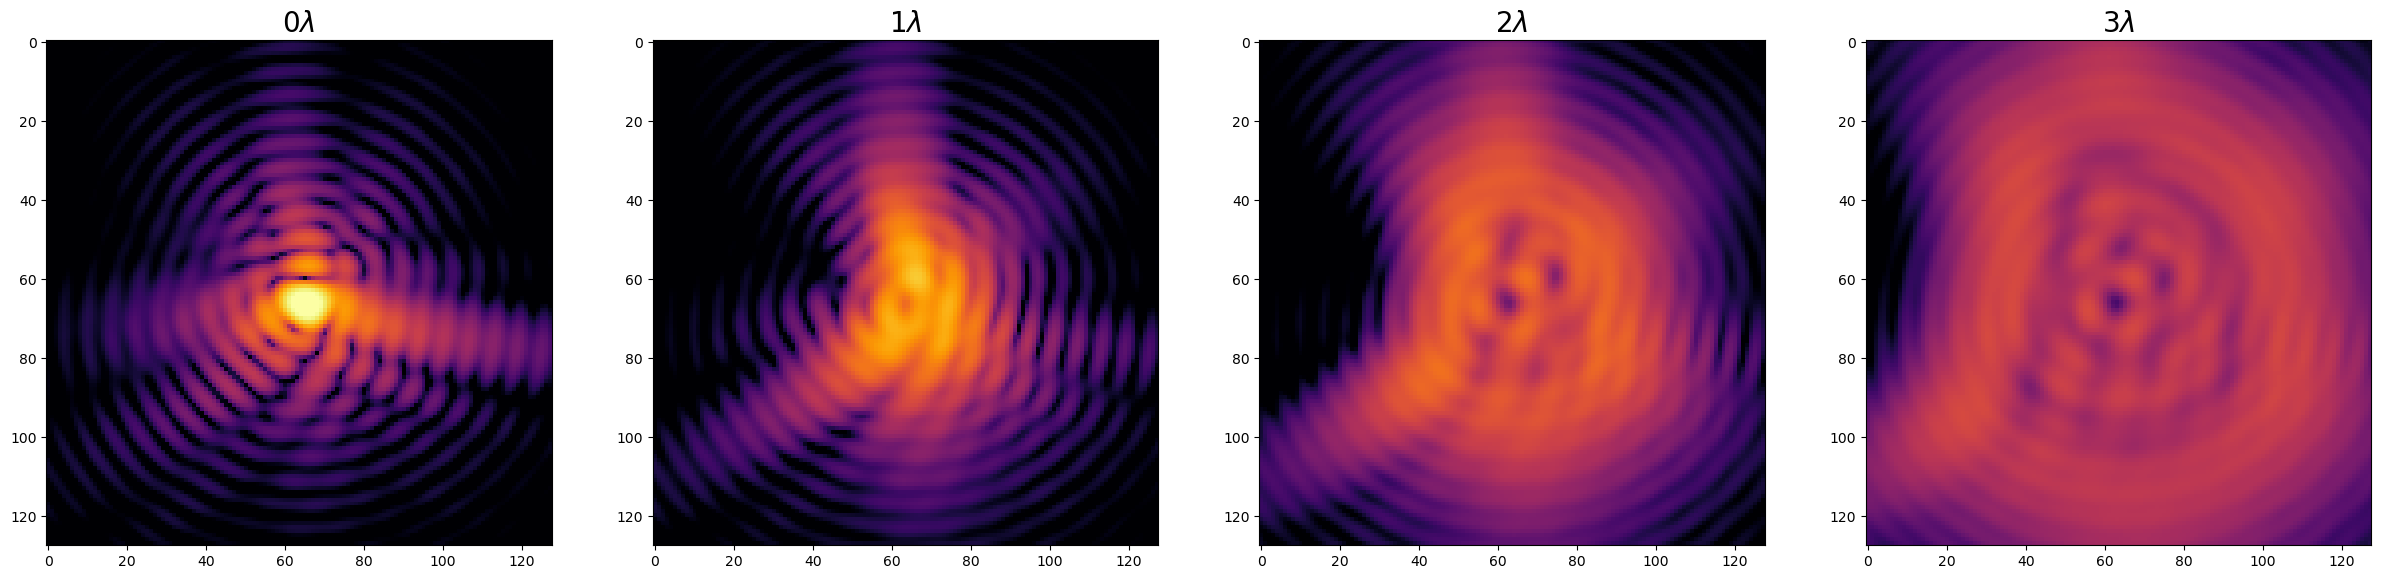

In [242]:
psflist = [psf0, psf1, psf2, psf3]
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(psflist,axs,titles):
    ax.set_title(title,fontsize=20)
    # _psf /= np.max(_psf)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

# Start pounding the `poi`

This is where we begin to use `poi`. We inherit the structure of the `dygdug` coronagraph design package (another `prysm` front-end) where we represent iterative algorithms as class objects. This enables the convenient storing of parameters in the phase retrieval algorithm, and lets us "play around".

`poi` begins by defining the phase retrieval problem as a single-PSF estimation with the `ADPhaseRetrieval` class. The associated inputs for this modal estimator are shown below.

In [243]:
import poi
adpr = poi.ADPhaseRetireval(amp=A, # pupil amplitude
                            amp_dx=dx_p, # pupil pixelscale, mm
                            efl=efl, # focal length, mm
                            wvl=wvl, # wavelength, microns
                            basis=basis_norm, # list of modes
                            target=psflist[0], # PSF to estimate phase of
                            img_dx=IC['image_dx'], # pixel scale of PSF, microns
                            defocus_waves=0, # amount of defocus, waves, in PSF
                            initial_phase=None) # initial phase guess

This class has three methods, the first `adpr.fwd()` computes the mean-squared error of the PSF estimate given the modal coefficiients with the target PSF supplied.

In [244]:
print('MSE of estimate and target')
adpr.fwd(np.zeros(len(coefs)))

MSE of estimate and target


805933.1904535987

The target and estimated PSFs are both accessible, and we plot them below. The estimate looks like a perfect PSF because it is, we supplied a coefficient vector of zeros above, so this estimation is that "no aberration" was experienced.

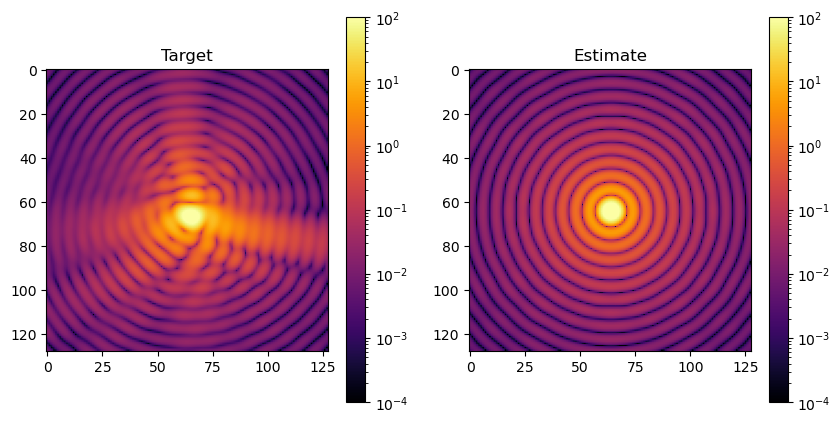

In [245]:
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=1e-4, vmax=1e2)
cm = 'inferno'
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title('Target')
plt.imshow(adpr.D, norm=norm, cmap=cm)
plt.colorbar()
plt.subplot(122)
plt.title('Estimate')
plt.imshow(adpr.I, norm=norm, cmap=cm)
plt.colorbar()
plt.show()


Key in algodiff is the adjoint model, which is accessible by the `adpr.rev()` method. This returns an array of partial derivatives of `adpr.fwd()` with respect to the input parameters (i.e., the modal coefficients) evaluated at the coefficient vector supplied to `adpr.fwd()`. You can think of these as the sensitivity of the error function to the input parameters.

In [246]:
adpr.rev(np.zeros_like(coefs))

array([-1.80563857e+06, -4.95245585e+06,  5.64323903e+02,  1.80907175e+02,
       -8.61221764e+02, -1.57017217e+06, -5.68567038e+05, -5.30870039e+03,
       -3.16073655e+04,  3.52155840e+02, -8.45206646e+02,  6.59825874e+01,
        4.36992356e+02,  7.68713770e+00, -2.05840615e+05, -5.70726086e+05,
       -1.19605948e+04, -2.25666723e+03,  2.77441095e+03,  3.55951754e+03,
        1.90364315e+02,  2.59050606e+01, -7.04075149e+02,  5.16577075e+00,
        2.18494847e+02,  1.76744647e+00, -2.72239748e+02, -2.23438237e+05,
       -8.03763522e+04, -1.02128071e+03, -4.76669726e+03,  1.67345542e+03,
        1.23829275e+03, -1.13824452e+03,  4.82724435e+02])

These two ingredients give us everything we need for gradient-based optimization. There is a convenience function that efficiently calls both of them, `adpr.fg()`, which is directly compatible with how `scipy.optimize.minimize` likes to call functions with analytical gradients, which we show below. Remember to set the `jac=True` kwarg. We will run this for 1000 iterations and see how good we do.

In [247]:
from scipy.optimize import minimize
results = minimize(adpr.fg, x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05933D+05    |proj g|=  4.95246D+06

At iterate    1    f=  1.45788D+05    |proj g|=  7.71774D+05

At iterate    2    f=  1.32979D+05    |proj g|=  1.11030D+05

At iterate    3    f=  1.32607D+05    |proj g|=  6.61378D+04

At iterate    4    f=  1.32240D+05    |proj g|=  7.40489D+04

At iterate    5    f=  1.20968D+05    |proj g|=  1.21494D+06

At iterate    6    f=  1.18168D+05    |proj g|=  1.44677D+06

At iterate    7    f=  1.06411D+05    |proj g|=  1.70065D+06

At iterate    8    f=  8.10085D+04    |proj g|=  1.43737D+06


 This problem is unconstrained.



At iterate    9    f=  3.00946D+04    |proj g|=  2.77159D+05

At iterate   10    f=  2.70441D+04    |proj g|=  8.08045D+04

At iterate   11    f=  2.53078D+04    |proj g|=  3.04592D+04

At iterate   12    f=  1.67009D+04    |proj g|=  1.26314D+05

At iterate   13    f=  1.61069D+04    |proj g|=  1.60129D+05

At iterate   14    f=  1.42569D+04    |proj g|=  7.78838D+04

At iterate   15    f=  8.61657D+03    |proj g|=  1.32506D+05

At iterate   16    f=  5.78129D+03    |proj g|=  5.11278D+04

At iterate   17    f=  5.14183D+03    |proj g|=  1.18720D+05

At iterate   18    f=  3.90395D+03    |proj g|=  3.22353D+04

At iterate   19    f=  3.50666D+03    |proj g|=  2.75498D+04

At iterate   20    f=  1.95409D+03    |proj g|=  3.39739D+04

At iterate   21    f=  1.50597D+03    |proj g|=  5.93891D+04

At iterate   22    f=  1.27781D+03    |proj g|=  3.02048D+04

At iterate   23    f=  1.24045D+03    |proj g|=  5.13010D+03

At iterate   24    f=  1.22700D+03    |proj g|=  5.81224D+03

At iter

Great so on an M1 macbook that did 1000 iterations in 15.4 seconds. Lets re-create that plotting function to see how our estimate has updated.

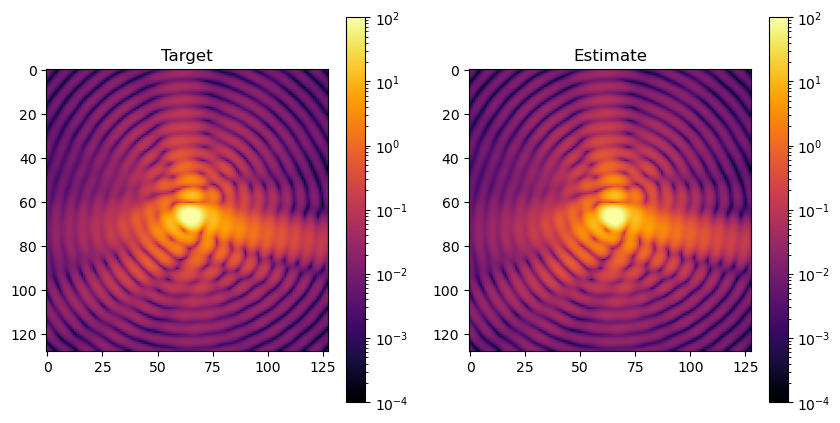

In [248]:
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=1e-4, vmax=1e2)
cm = 'inferno'
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title('Target')
plt.imshow(adpr.D, norm=norm, cmap=cm)
plt.colorbar()
plt.subplot(122)
plt.title('Estimate')
plt.imshow(adpr.I, norm=norm, cmap=cm)
plt.colorbar()
plt.show()


We are looking _much_ closer in terms of an intensity estimation. However, at focus we know that even aberrations tend to look the same regardless of the sign, so let's examine how the actual phase aberration was reconstructed.

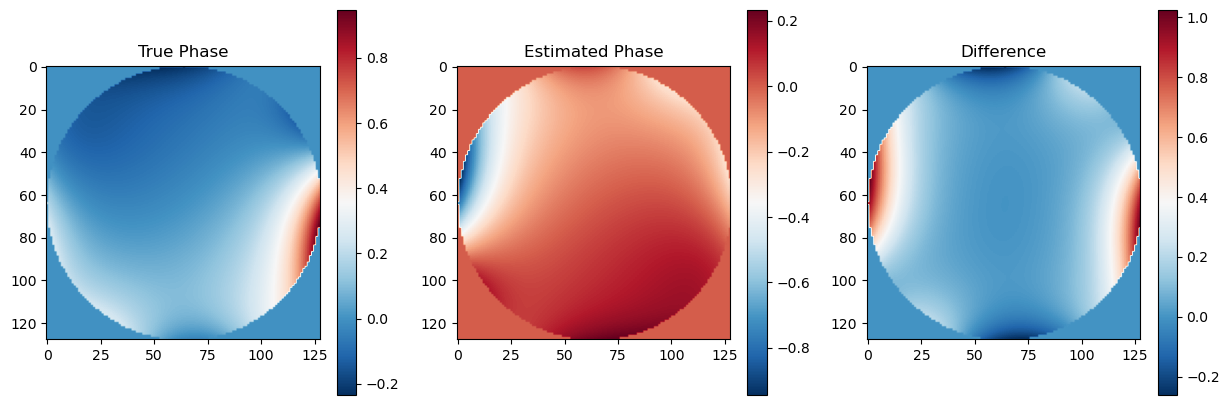

RMS nanometers difference =  181.12257429771802


In [249]:
cm = 'RdBu_r'
plt.figure(figsize=[15, 5])
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
plt.imshow(diff * A, cmap=cm)
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)


It looks like we swan-dived on a solution that was indeed accurate! 15 seconds to get a sub-nm RMS is not too shabby. However in this case we truly just got lucky with our phase estimation. In order to make sure that we hit an equivalent solution every time - we need to incorporate focus diversity.

# Focus Diverse Phase Retrieval
We've configured the phase retireval problem as a nonlinear optimization problem where we have derived a forward model and its analytical gradient. You can then think of focus-diverse phase retrieval as a joint nonlinear optimization problem. We have two models $f_{1}, f_{2}$ that operate on the same parameter vector $\mathbf{\theta}$ to produce some error with respect to a target. 

The joint optimization of these parameters can be modeled by a linear combination of the error functions and gradients, which is relatively trivial to implement. In `poi`, we've implemented this as a class called `ParallelADPhaseRetrieval` to represent that it truly is an optimization of two problems with the same parameters.

Below we re-define two separate `ADPhaseRetrieval` objects and given them each a different PSF and defocus value. These object are fed to the `ParallelADPhaseRetrieval` class, which has an `.fg()` method that we can use to do joint optimization.

In [250]:
adpr0 = poi.ADPhaseRetireval(amp=A, # pupil amplitude
                            amp_dx=dx_p, # pupil pixelscale, mm
                            efl=efl, # focal length, mm
                            wvl=wvl, # wavelength, microns
                            basis=basis_norm, # list of modes
                            target=psflist[0], # PSF to estimate phase of
                            img_dx=IC['image_dx'], # pixel scale of PSF, microns
                            defocus_waves=0, # amount of defocus, waves, in PSF
                            initial_phase=None) # initial phase guess

# Just change target and defocus_waves for a defocused PSF!
adpr1 = poi.ADPhaseRetireval(amp=A, # pupil amplitude
                            amp_dx=dx_p, # pupil pixelscale, mm
                            efl=efl, # focal length, mm
                            wvl=wvl, # wavelength, microns
                            basis=basis_norm, # list of modes
                            target=psflist[1], # PSF to estimate phase of
                            img_dx=IC['image_dx'], # pixel scale of PSF, microns
                            defocus_waves=1, # amount of defocus, waves, in PSF
                            initial_phase=None) # initial phase guess

fdpr = poi.ParallelADPhaseRetrieval(optlist=[adpr0, adpr1])

Now we run the optimization problem, same as for the single-plane case.

In [251]:
results = minimize(fdpr.fg, x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52031D+05    |proj g|=  5.01632D+06

At iterate    1    f=  1.83968D+05    |proj g|=  8.11789D+05

At iterate    2    f=  1.68991D+05    |proj g|=  1.28116D+05

At iterate    3    f=  1.14407D+05    |proj g|=  1.43250D+06

At iterate    4    f=  1.10967D+05    |proj g|=  1.55049D+06

At iterate    5    f=  9.41140D+04    |proj g|=  1.44702D+06



 This problem is unconstrained.


At iterate    6    f=  2.59476D+04    |proj g|=  1.94647D+05

At iterate    7    f=  2.24599D+04    |proj g|=  8.17643D+04

At iterate    8    f=  2.11441D+04    |proj g|=  7.61663D+04

At iterate    9    f=  1.16268D+04    |proj g|=  3.71526D+05

At iterate   10    f=  8.37138D+03    |proj g|=  2.32687D+05

At iterate   11    f=  6.20875D+03    |proj g|=  2.02009D+04

At iterate   12    f=  6.06168D+03    |proj g|=  2.53043D+04

At iterate   13    f=  5.10390D+03    |proj g|=  3.88271D+04

At iterate   14    f=  4.03211D+03    |proj g|=  2.33375D+04

At iterate   15    f=  3.26349D+03    |proj g|=  5.10923D+04

At iterate   16    f=  2.56401D+03    |proj g|=  3.49207D+04

At iterate   17    f=  2.02620D+03    |proj g|=  2.25619D+04

At iterate   18    f=  1.48424D+03    |proj g|=  1.89791D+04

At iterate   19    f=  1.27966D+03    |proj g|=  3.31602D+04

At iterate   20    f=  1.08295D+03    |proj g|=  1.88206D+04

At iterate   21    f=  9.40260D+02    |proj g|=  5.91441D+03

At itera

This took slightly longer at 23s to do two phase retrieval experiments instead of one. First let's look at the PSFs, there are two now so we have to examine both of them. We can call them right out of `fdpr.optlist` so we can literally re-use the same plotting code.

/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_51373/2052919723.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


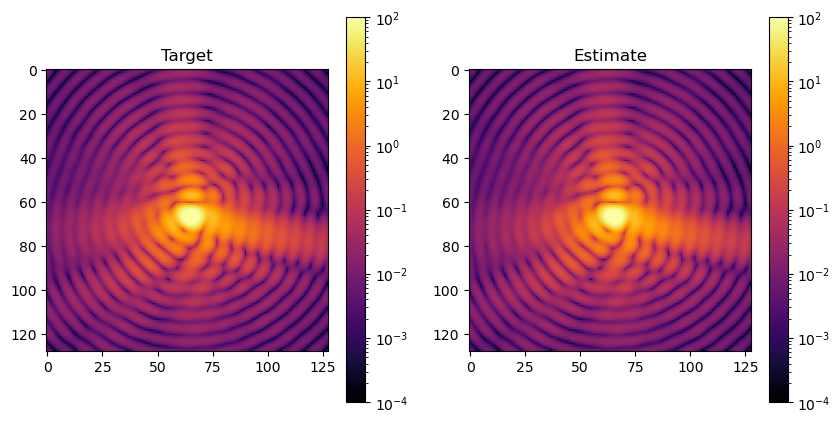

/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_51373/2052919723.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


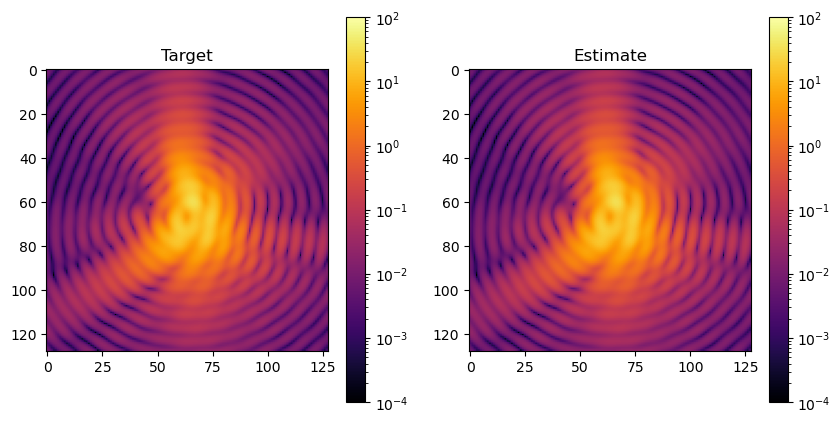

In [252]:
norm = LogNorm(vmin=1e-4, vmax=1e2)
cm = 'inferno'
adpr = fdpr.optlist[0]
plt.figure(figsize=[10, 5])
plt.title('Focus Position 1')
plt.subplot(121)
plt.title('Target')
plt.imshow(adpr.D, norm=norm, cmap=cm)
plt.colorbar()
plt.subplot(122)
plt.title('Estimate')
plt.imshow(adpr.I, norm=norm, cmap=cm)
plt.colorbar()
plt.show()

adpr = fdpr.optlist[1]
plt.figure(figsize=[10, 5])
plt.title('Focus Position 2')
plt.subplot(121)
plt.title('Target')
plt.imshow(adpr.D, norm=norm, cmap=cm)
plt.colorbar()
plt.subplot(122)
plt.title('Estimate')
plt.imshow(adpr.I, norm=norm, cmap=cm)
plt.colorbar()
plt.show()

The PSF estimation is great! Now let's take a look at the phase estimate.

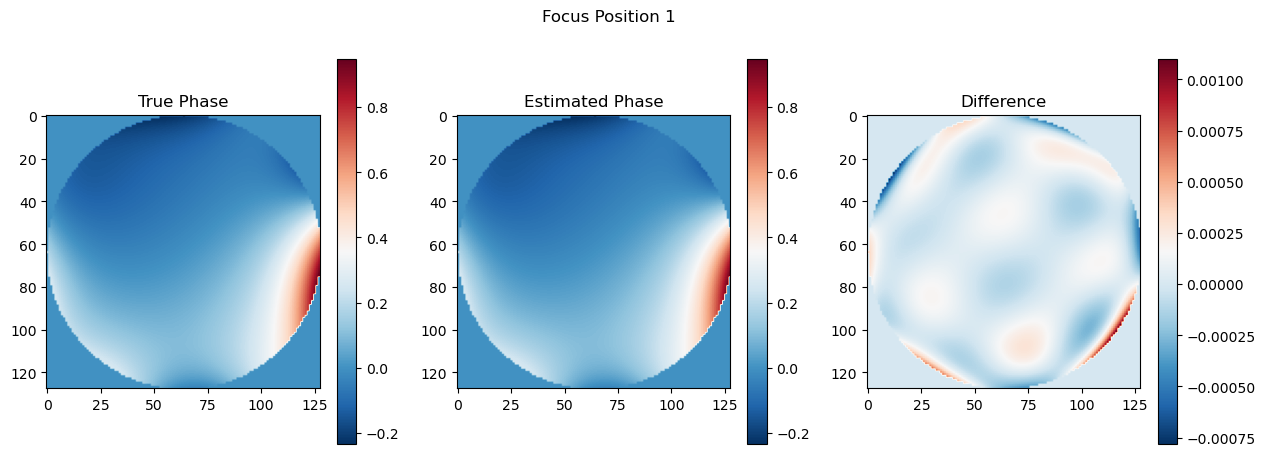

RMS nanometers difference =  0.13394786749202714


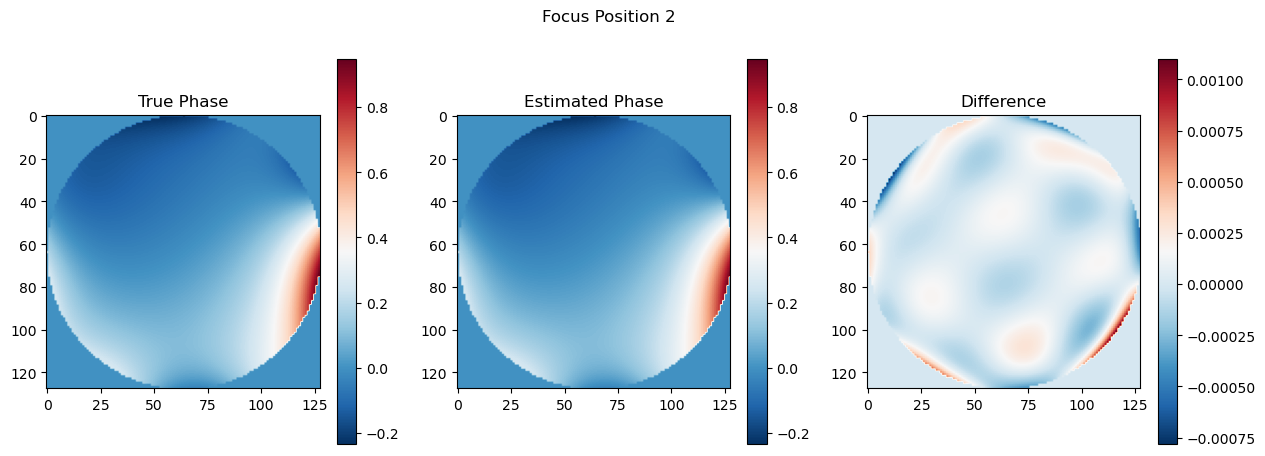

RMS nanometers difference =  0.13394786749202714


In [253]:
cm = 'RdBu_r'
adpr = fdpr.optlist[0]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 1')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
plt.imshow(diff * A, cmap=cm)
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

adpr = fdpr.optlist[1]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 2')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
plt.imshow(diff * A, cmap=cm)
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

And the phase estimate is a factor of 5 better at 0.1nm! Using the `.cost` attribute we can examine the rate of convergence to see if we optimized enough. Below the plot shows that the mean squared error improved by over 6 orders of magnitude - we are doing quite well!

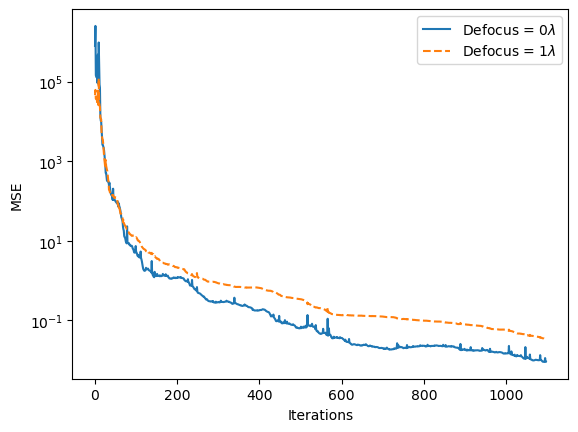

In [254]:
plt.plot()
plt.plot(fdpr.optlist[0].cost, label='Defocus = '+r'$0\lambda$')
plt.plot(fdpr.optlist[1].cost, label='Defocus = '+r'$1\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

To wrap it up, we've outlined how algorithmic differentiation with nonlinear optimization can help us do phase retrieval. Our expression of the problem is to break it down into the smallest possible problem one can solve - the monochromatic case at a single focal plane. The model $f$ acts on a vector of parameters $\boldsymbol{\theta}$ to produce an estimate of the PSF $I_{psf}$

$$f(\boldsymbol{\theta}) \rightarrow I_{psf}.$$

Extension to focus diversity or the polychromatic case is a simple matter of constructing a vector of these models $\mathbf{f}$. As an example for a simulation with three different wavelengths and two defocus positions is shown below.

$$
\mathbf{f}(\boldsymbol{\theta})
=
\begin{pmatrix}
f_{\lambda_1}(\boldsymbol{\theta}) \\
f_{\lambda_2}(\boldsymbol{\theta}) \\
f_{\lambda_3}(\boldsymbol{\theta}) \\
f_{\Delta_1}(\boldsymbol{\theta}) \\
f_{\Delta_2}(\boldsymbol{\theta}) \\
\end{pmatrix}
$$

The joint optimization of each of these models is then the sum over the error functions and gradients, which we have implemented in `poi.ParallelADPhaseRetrieval`. However, the simulations above ignore that noise exists, which is _extremely important_. So in the next section we will try for the case where we add Poisson noise.

# Snap back to reality oop there goes gravity
Welcome to the case of noise, one of the _many_ practical things that can complicate phase retrieval. We assume that we are working with a reasonably bright signal such that photon noise is the dominant noise source. We will just be calling a poisson distribution as-is without additional scaling of the PSF to make sure we have enough energy. Below we plot the noisy PSFs to show that we added a considerable deal of noise. There are two important practical steps here that do matter which I want to highlight:
- Masking negative or bad values: These will inject NaNs and break energy conservation into your estimate, which will cause the problem to diverge very quickly
- Scaling the approximate power: `poi`'s phase retrieval estimator does direct comparison on the target and model PSFs. This means that if there is an energy difference - there will be a very large mean squared error that phase retrieval cannot correct for with phase aberrations (well it will try, and it will be gross). So we scale the expected power by the nominal PSF. Here we use the already initialized nominal PSFs, but in practice, you can use something like the following:

```python
# init phase retrieval
adpr = ADPhaseRetrieval(*args, **kwargs)

# warm up the phase retrieval
adpr.fwd(np.zeros_like(basis))

# get nominal psf
nom_psf = adpr.I
```

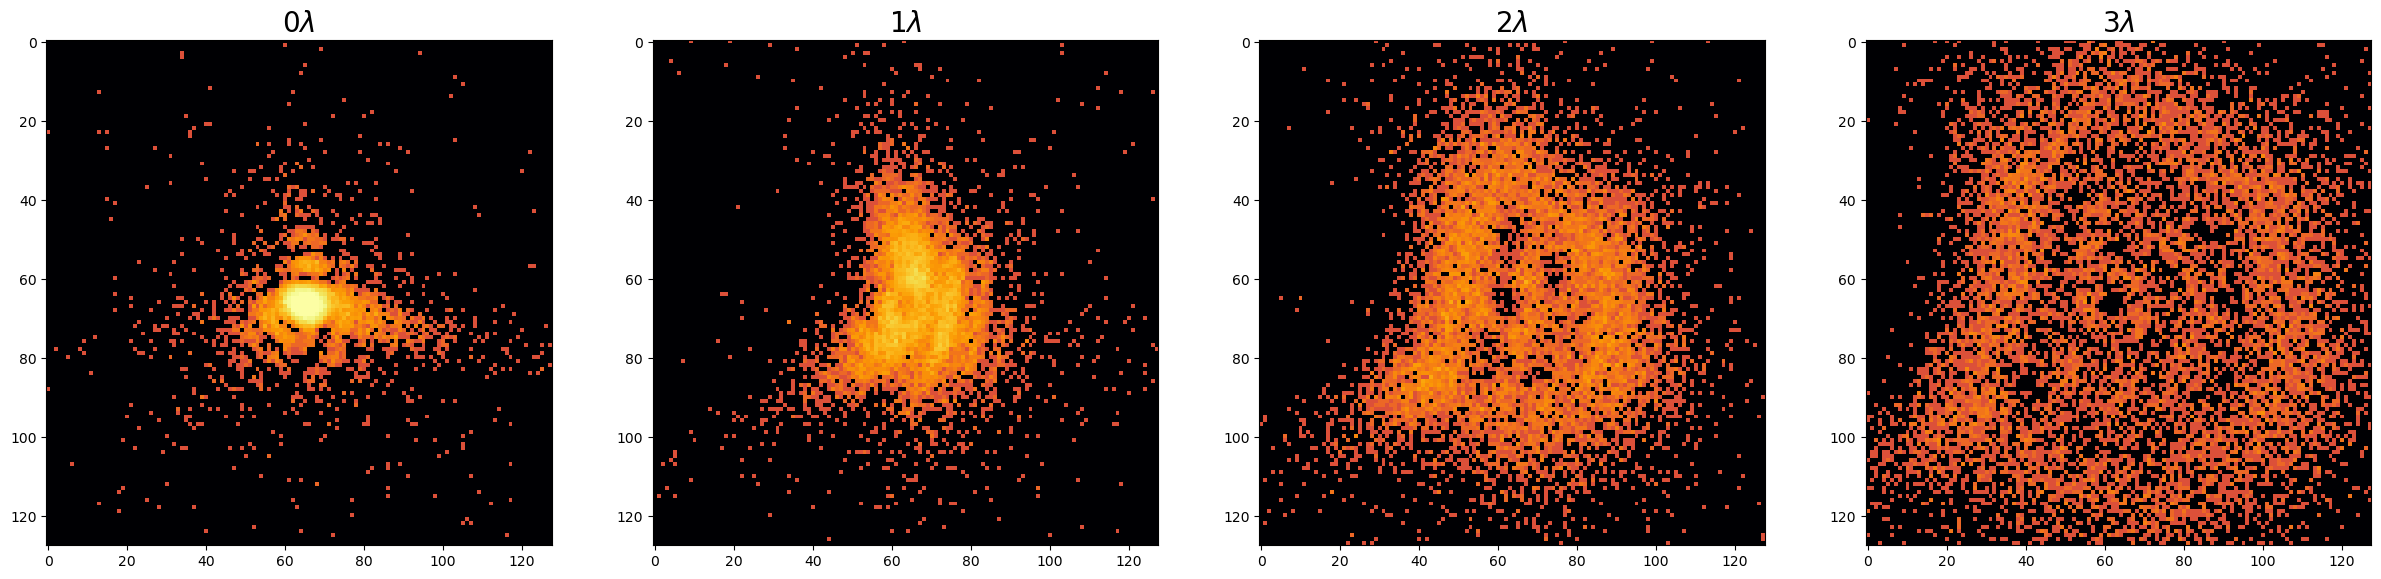

In [255]:
noisy_psfs = [np.random.poisson(p).astype(np.float64) for p in psflist]

# mask low values
for i, p in enumerate(noisy_psfs):
    p[p <= 1e-10] = 1e-20
    noisy_psfs[i] = p

# make sure energy is simmilar
for i, pnom in enumerate(psflist):
    energy_nom = np.sum(pnom)
    energy_noisy = np.sum(noisy_psfs[i])
    noisy_psfs[i] *=  (energy_nom / energy_noisy)

# plot noisy
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(noisy_psfs,axs,titles):
    ax.set_title(title,fontsize=20)
    im = ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-3)
# fig.colorbar(im)
plt.show()

Here we initialize all of our phase retireval "problems" and pass them as a list to the parallel iterator. This time let's use all of our defocus positions!

In [256]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, noisy_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, noisy_psfs[1], IC['image_dx'], defocus_waves=1)
adpr2 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, noisy_psfs[2], IC['image_dx'], defocus_waves=2)
adpr3 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, noisy_psfs[3], IC['image_dx'], defocus_waves=3)

# set up the net optimizer
optlist = [adpr0, adpr1, adpr2, adpr3]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91933D+05    |proj g|=  4.96802D+06

At iterate    1    f=  2.45957D+05    |proj g|=  8.27276D+05

At iterate    2    f=  2.30233D+05    |proj g|=  1.59795D+05


 This problem is unconstrained.



At iterate    3    f=  1.27909D+05    |proj g|=  1.06883D+06

At iterate    4    f=  1.25852D+05    |proj g|=  1.09744D+06

At iterate    5    f=  1.08788D+05    |proj g|=  8.18026D+05

At iterate    6    f=  8.40749D+04    |proj g|=  1.34267D+05

At iterate    7    f=  8.08249D+04    |proj g|=  1.15388D+05

At iterate    8    f=  7.18248D+04    |proj g|=  2.57602D+05

At iterate    9    f=  6.41999D+04    |proj g|=  2.40818D+05

At iterate   10    f=  5.85290D+04    |proj g|=  1.13522D+05

At iterate   11    f=  5.69447D+04    |proj g|=  2.47364D+04

At iterate   12    f=  5.65864D+04    |proj g|=  2.69186D+04

At iterate   13    f=  5.63252D+04    |proj g|=  4.45566D+04

At iterate   14    f=  5.59255D+04    |proj g|=  4.24475D+04

At iterate   15    f=  5.47515D+04    |proj g|=  3.97751D+04

At iterate   16    f=  5.38280D+04    |proj g|=  4.63308D+04

At iterate   17    f=  5.36283D+04    |proj g|=  4.02585D+04

At iterate   18    f=  5.33876D+04    |proj g|=  1.19561D+04

At iter

Took about 32s for 1000 iterations and 4 joint optimizations, let's see how we did! Since we've already proved that focus diversity will retrieve the same results, we will just examine the "in-focus" phase estimator.

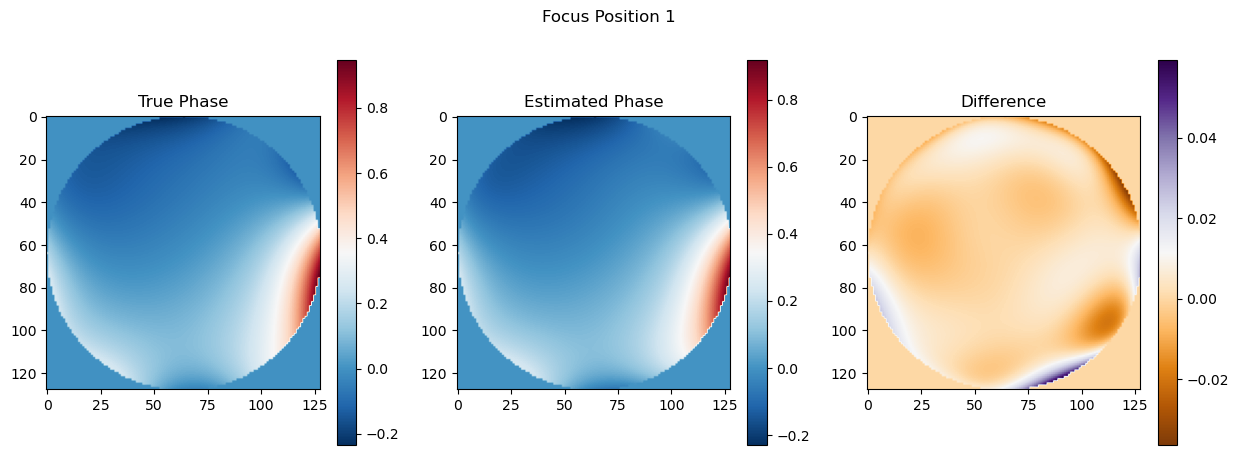

RMS nanometers difference =  7.1677673344677695


In [257]:
cm = 'RdBu_r'
adpr = fdpr.optlist[0]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 1')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
plt.imshow(diff * A, cmap='PuOr')
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

Me, Jaren, is suprised at how well this worked - 5nm RMS difference is quite nice! But keep in mind that there are still a lot of things that are "optimal" about this simulation. This includes, but is not limited to:
- Perfect defocus knowledge
- Perfect PSF centering
- Zero non-common-path aberrations between defocus positions (this depends on how you apply defocus)
- Perfect knowledge of our optical system (focal length, pixel size, aperture illumination)

Below we compare the PSF estimations and find that indeed - we recover the PSFs as expected!

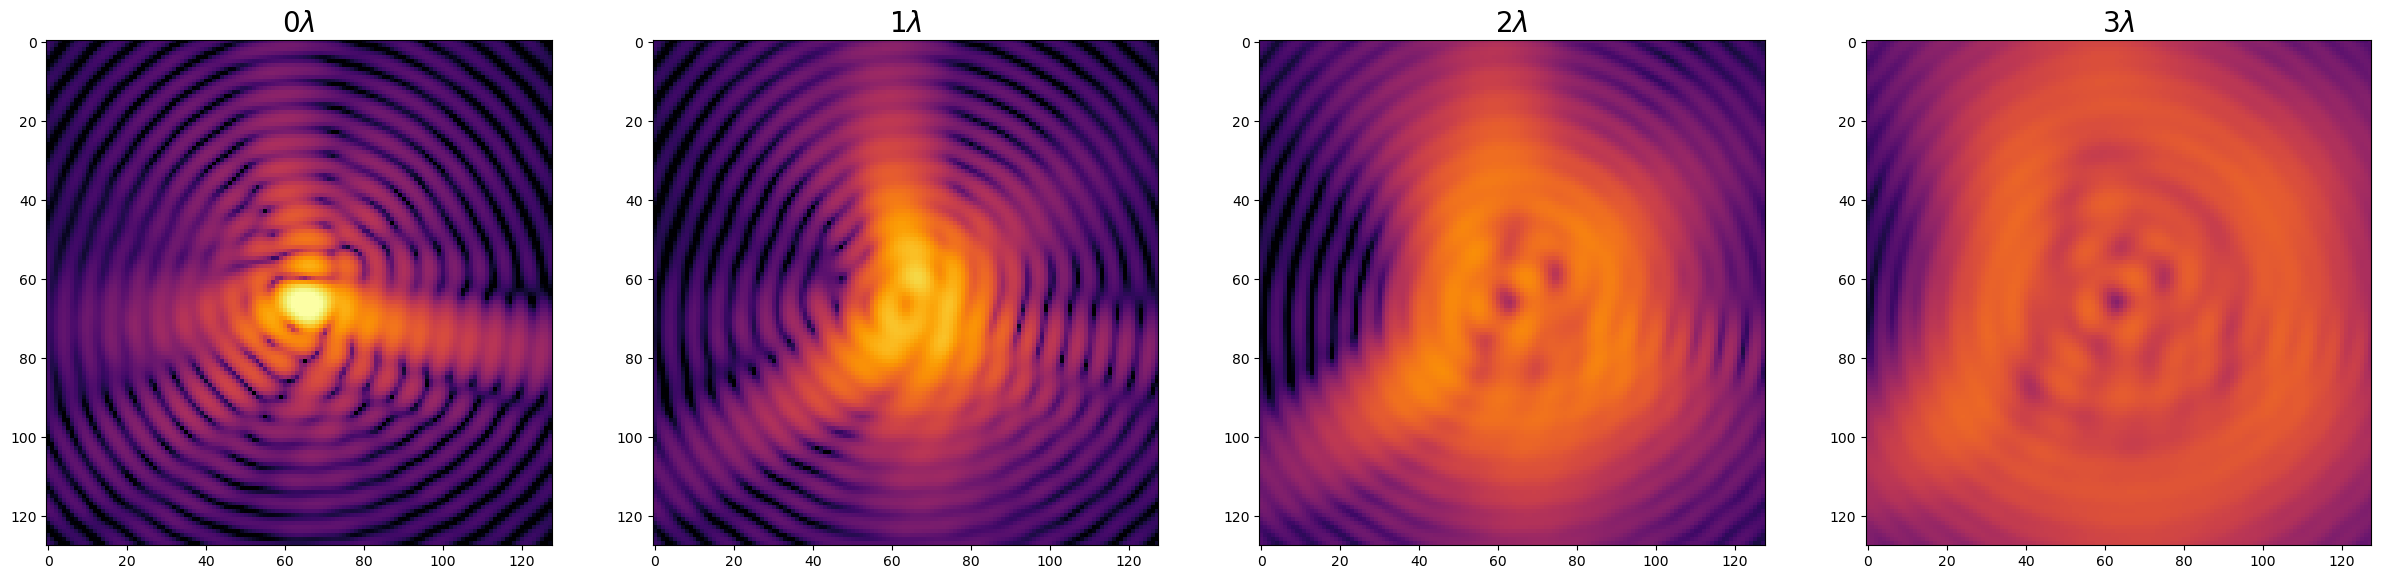

In [258]:
final_psfs = [opt.I for opt in fdpr.optlist]

# plot final estimate
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(final_psfs,axs,titles):
    ax.set_title(title,fontsize=20)
    im = ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-3)
plt.show()

A very convenient aspect of this modal estimation is that the phase solution is completely unwrapped. In the presence of strong high-frequencyc aberrations, traditional iterative transform algorithms (e.g. Gerchberg-Saxton, Misel's extension to two PSFs for focus diversity) will return a wrapped phase estimation. Phase unwrapping is nontrivial, particularly in the presence of noise. However, a modal optimization in the way we have constructed it here is entirely insensitive to this effect!

# Model Uncertainty

A lot of aspects of this demo were highly idealized, and consequently we achieved rather ideal performance. Next, we explore the impact of model uncertainty on our phase retrieval estimate. We will then follow with a clever strategy with which we can remedy it. 

We begin by re-creating our PSFs with some error in the defocus position. We choose errors on the scale of waves (albeit randomly) to really "mess up" our knowledge.

In [259]:
defocus_error = np.random.random(3)
print(f'error in defocus, waves = {defocus_error}')
psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1 + defocus_error[0])
psf2 = prop_to_focus(wf, defocus_waves=2 + defocus_error[1])
psf3 = prop_to_focus(wf, defocus_waves=3 + defocus_error[2])

error in defocus, waves = [0.9245365  0.93463587 0.48601365]


As you can see, the estimates for 1-2 waves of defocus are quite bad!

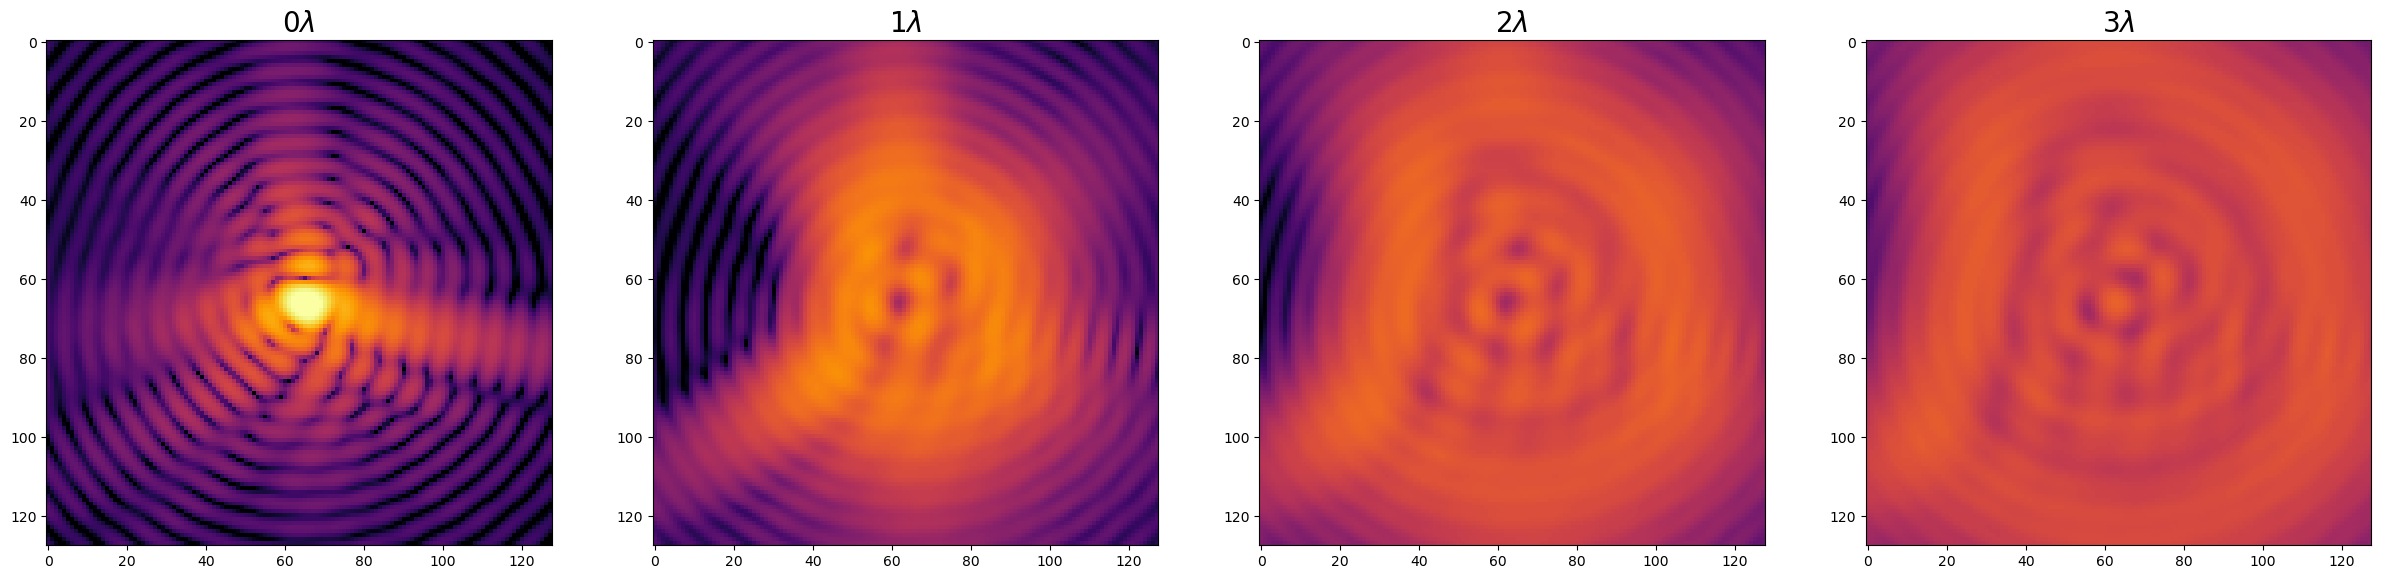

In [260]:
error_psfs = [psf0, psf1, psf2, psf3]

# plot final estimate
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(error_psfs,axs,titles):
    ax.set_title(title,fontsize=20)
    im = ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-3)
plt.show()

Let us next examine how this messes up the convergence of the algorithm.

In [261]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[1], IC['image_dx'], defocus_waves=1)
adpr2 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[2], IC['image_dx'], defocus_waves=2)
adpr3 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[3], IC['image_dx'], defocus_waves=3)

# set up the net optimizer
optlist = [adpr0, adpr1, adpr2, adpr3]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75417D+05    |proj g|=  4.95231D+06

At iterate    1    f=  2.16476D+05    |proj g|=  7.69837D+05

At iterate    2    f=  2.02687D+05    |proj g|=  1.41220D+05

At iterate    3    f=  1.96407D+05    |proj g|=  2.50388D+05

At iterate    4    f=  1.68529D+05    |proj g|=  1.31101D+06


 This problem is unconstrained.



At iterate    5    f=  1.59964D+05    |proj g|=  1.60405D+06

At iterate    6    f=  1.44370D+05    |proj g|=  1.66070D+06

At iterate    7    f=  9.64661D+04    |proj g|=  1.18983D+06

At iterate    8    f=  5.99364D+04    |proj g|=  6.87039D+05

At iterate    9    f=  4.77768D+04    |proj g|=  1.91121D+05

At iterate   10    f=  4.49746D+04    |proj g|=  1.40360D+05

At iterate   11    f=  4.33341D+04    |proj g|=  1.58608D+05

At iterate   12    f=  4.00538D+04    |proj g|=  1.09835D+05

At iterate   13    f=  3.90927D+04    |proj g|=  7.71918D+04

At iterate   14    f=  3.86705D+04    |proj g|=  5.90117D+04

At iterate   15    f=  3.84043D+04    |proj g|=  4.51193D+04

At iterate   16    f=  3.73859D+04    |proj g|=  7.17045D+04

At iterate   17    f=  3.69328D+04    |proj g|=  3.79262D+04

At iterate   18    f=  3.65366D+04    |proj g|=  1.34934D+04

At iterate   19    f=  3.64651D+04    |proj g|=  1.58185D+04

At iterate   20    f=  3.63130D+04    |proj g|=  7.55209D+03

At iter

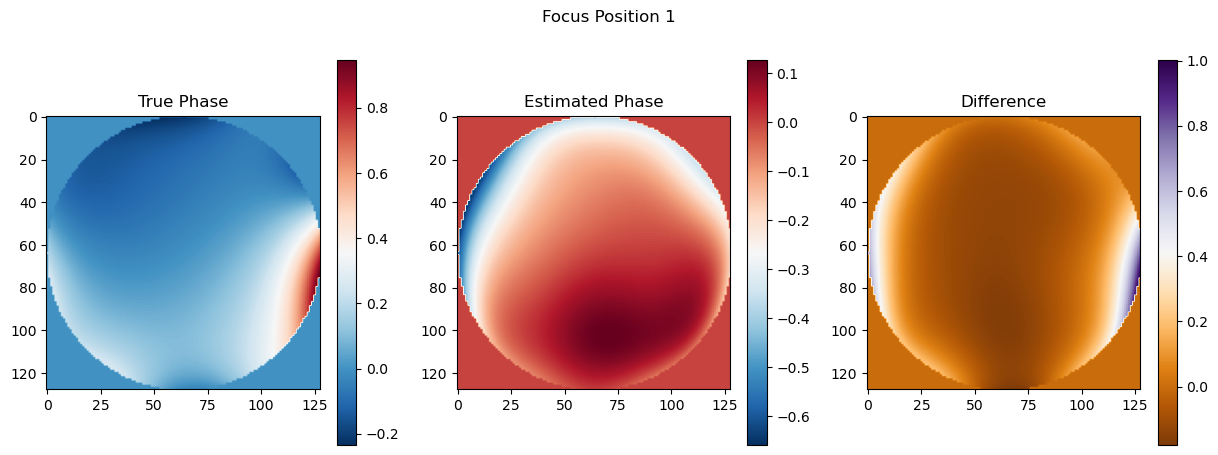

RMS nanometers difference =  169.9136818598969


In [262]:
cm = 'RdBu_r'
adpr = fdpr.optlist[0]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 1')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
diff -= np.mean(diff[A==1])
plt.imshow(diff * A, cmap='PuOr')
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

Our phase estimate got really messed up! Let's examine the convergence of the algorithm to try and understand what happened.

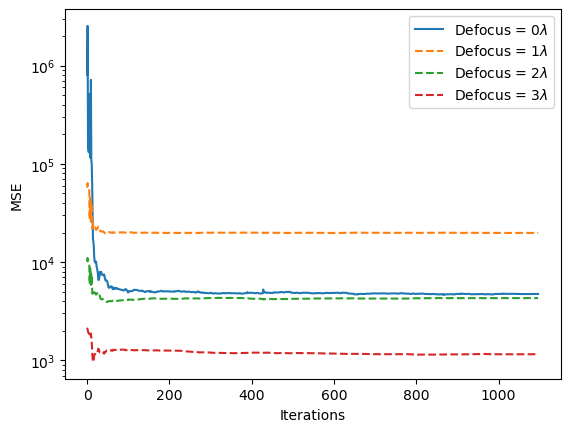

In [263]:
plt.plot()
plt.plot(fdpr.optlist[0].cost, label='Defocus = '+r'$0\lambda$')
for i in range(1,4):
    plt.plot(fdpr.optlist[i].cost, label=f'Defocus = {i}'+r'$\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

It appears that it swan dived onto a solution that it could not do better than. All of the defocus positions should decrease monotonically, but when they get stuck like this we know it's indicative of a problem. So, we need to come up with a way to solve for this so that we are insensitive to errors in our understanding of defocus.

# Learning Model Uncertainty

The neat thing about algorithmic differentiation is that you can fit to these types of errors. It just requires some weird code, which we will build here in this notebook. But first, the math! The wavefront error in the pupil $W$ as implemented in `poi.ADPhaseRetrieval` is expressed as a sum of two sources of wavefront error, the modal basis expansion of the wavefront error we are trying to fit for $W_{modes}$, and a defocus polynomial $W_{diversity}$.

$$W = W_{modes} + W_{diversity} = \sum_{n} a_{n} Z_{n} + W_{020} \cdot r^{2}$$

Following the gradient backpropagation rules in Jurling and Fienup 2014, the gradient of $W_{modes}$, $\bar{W}_{modes}$ can be expressed by the following relation:

$$\bar{W}_{modes} = \bar{W}$$

This is powerful because the backpropagation of the gradient through the basis expansion is not at all dependent on the defocus diversity applied. They are independent. For now, we have been treating $W_{diversity}$ as a known offset to the wavefront error. But, if we wanted to fit for it, it would be as simple as propagating the gradient up a different path.

$$\bar{W}_{diversity} = \bar{W}$$

In terms of how to implement this, we essentially need to feed each of the phase retrieval problems $f_{n}$ an additional mode that corresponds to an error in defocus position. We begin with the `ParallelFDPR` class below that is identical to `ParrallelADPhaseRetrieval`, with the addition of a new attribute `ind_modes`. This will be a list containing our independent focus modes.

In [264]:
class ParallelFDPR:

    def __init__(self, optlist):

        self.optlist = optlist

        self.f = 0
        self.g = 0
        self.cost = []

    def refresh(self):
        self.f = 0
        self.g = 0
    
    def fg(self, x):

        # reset the f, g values
        self.refresh()

        # get the common modes

        # just sum them
        for i, opt in enumerate(self.optlist):
            f, g = opt.fg(x)
            self.f += f
            self.g += g
        
        self.cost.append(self.f)

        return self.f, self.g
    

    def fg_diversity(self, x):

        # reset the f, g values
        self.refresh()

        # just sum them
        for i, opt in enumerate(self.optlist):
            
            # x_pick = x[i]
            f, g = opt.fg(x)
            self.f += f
            self.g += g
        
        self.cost.append(self.f)

        return self.f, self.g

We will re-initialize the optimizers to clear them of the previous experiment.

In [265]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[1], IC['image_dx'], defocus_waves=1)
adpr2 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[2], IC['image_dx'], defocus_waves=2)
adpr3 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[3], IC['image_dx'], defocus_waves=3)

# set up the net optimizer
optlist = [adpr0, adpr1, adpr2, adpr3]
fdpr = ParallelFDPR(optlist)

# Begin by optimizing for the common modes

In [266]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':100})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75417D+05    |proj g|=  4.95231D+06

At iterate    1    f=  2.16476D+05    |proj g|=  7.69837D+05

At iterate    2    f=  2.02687D+05    |proj g|=  1.41220D+05

At iterate    3    f=  1.96407D+05    |proj g|=  2.50388D+05

At iterate    4    f=  1.68529D+05    |proj g|=  1.31101D+06

At iterate    5    f=  1.59964D+05    |proj g|=  1.60405D+06


 This problem is unconstrained.



At iterate    6    f=  1.44370D+05    |proj g|=  1.66070D+06

At iterate    7    f=  9.64661D+04    |proj g|=  1.18983D+06

At iterate    8    f=  5.99364D+04    |proj g|=  6.87039D+05

At iterate    9    f=  4.77768D+04    |proj g|=  1.91121D+05

At iterate   10    f=  4.49746D+04    |proj g|=  1.40360D+05

At iterate   11    f=  4.33341D+04    |proj g|=  1.58608D+05

At iterate   12    f=  4.00538D+04    |proj g|=  1.09835D+05

At iterate   13    f=  3.90927D+04    |proj g|=  7.71918D+04

At iterate   14    f=  3.86705D+04    |proj g|=  5.90117D+04

At iterate   15    f=  3.84043D+04    |proj g|=  4.51193D+04

At iterate   16    f=  3.73859D+04    |proj g|=  7.17045D+04

At iterate   17    f=  3.69328D+04    |proj g|=  3.79262D+04

At iterate   18    f=  3.65366D+04    |proj g|=  1.34934D+04

At iterate   19    f=  3.64651D+04    |proj g|=  1.58185D+04

At iterate   20    f=  3.63130D+04    |proj g|=  7.55209D+03

At iterate   21    f=  3.60884D+04    |proj g|=  1.25538D+04

At iter

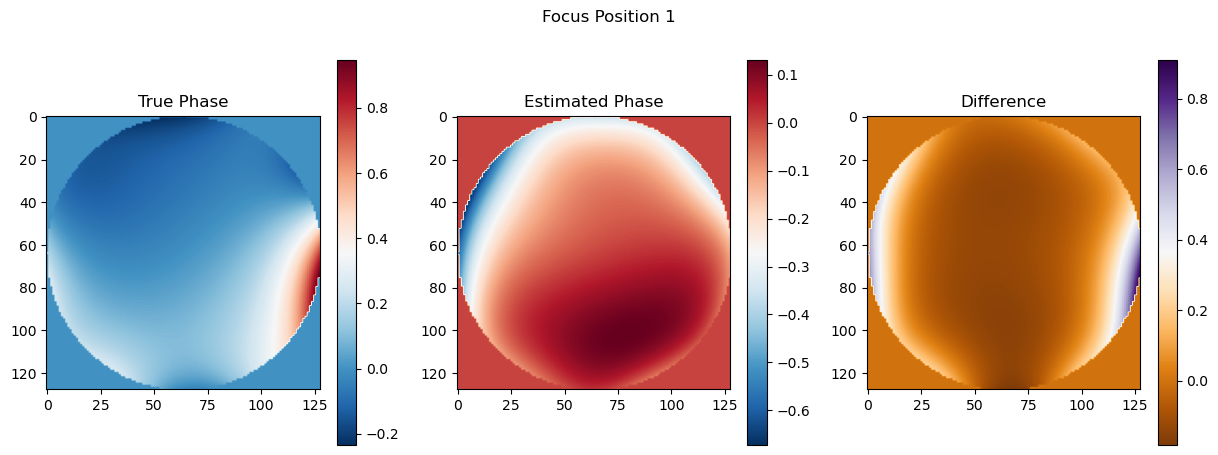

RMS nanometers difference =  167.91294863512124


In [267]:
cm = 'RdBu_r'
adpr = fdpr.optlist[0]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 1')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
diff -= np.mean(diff[A==1])
plt.imshow(diff * A, cmap='PuOr')
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

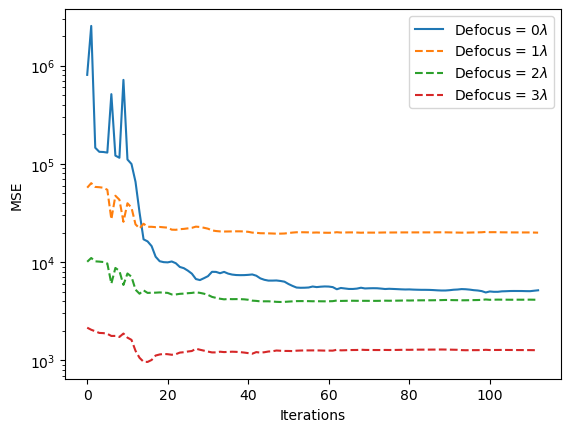

In [268]:
plt.plot()
plt.plot(fdpr.optlist[0].cost, label='Defocus = '+r'$0\lambda$')
for i in range(1,4):
    plt.plot(fdpr.optlist[i].cost, label=f'Defocus = {i}'+r'$\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# Next we optimize for focus modes

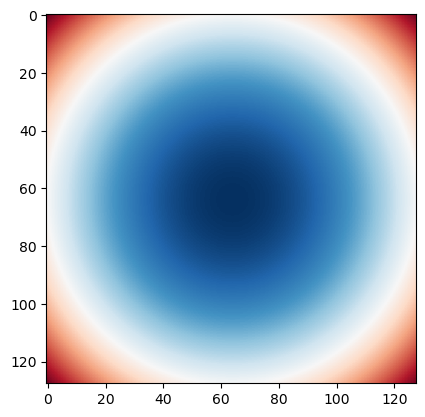

In [269]:
uncertainty = [basis[2] for p in error_psfs]
plt.imshow(basis[2], cmap='RdBu_r')

# Next we re-initialize the iterators with the new phase starting guess. 

Here we treat them as independent problems again. This time we will only iterate on the out-of-focus PSFs so that our in-focus PSF doesn't get stuck in the diversity trap.

In [270]:
# Get the phase guess
phase_guess = sum_of_2d_modes(basis_norm, results.x)

# configure the individual optimizers with only a focus polynomial
adpr1 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[1], IC['image_dx'], defocus_waves=1, initial_phase=phase_guess)
adpr2 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[2], IC['image_dx'], defocus_waves=2, initial_phase=phase_guess)
adpr3 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[3], IC['image_dx'], defocus_waves=3, initial_phase=phase_guess)

In [271]:
options = {'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000}
results1 = minimize(adpr1.fg, x0=results.x, method='L-BFGS-B', jac=True, options=options)
results2 = minimize(adpr2.fg, x0=results.x, method='L-BFGS-B', jac=True, options=options)
results3 = minimize(adpr3.fg, x0=results.x, method='L-BFGS-B', jac=True, options=options)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99544D+04    |proj g|=  3.20280D+04

At iterate    1    f=  5.88147D+03    |proj g|=  1.48061D+04

At iterate    2    f=  4.73152D+03    |proj g|=  4.93497D+03

At iterate    3    f=  4.03639D+03    |proj g|=  5.07673D+03

At iterate    4    f=  3.27330D+03    |proj g|=  3.48174D+03

At iterate    5    f=  2.74593D+03    |proj g|=  3.77465D+03

At iterate    6    f=  2.44863D+03    |proj g|=  2.24579D+03

At iterate    7    f=  2.23525D+03    |proj g|=  2.20563D+03

At iterate    8    f=  1.83783D+03    |proj g|=  2.48066D+03

At iterate    9    f=  1.32408D+03    |proj g|=  3.76877D+03

At iterate   10    f=  6.61719D+02    |proj g|=  3.18334D+03

At iterate   11    f=  2.55516D+02    |proj g|=  2.49496D+03

At iterate   12    f=  1.44377D+02    |proj g|=  7.92818D+02

At iterate   13    f=  1.0

 This problem is unconstrained.



At iterate   23    f=  1.32811D+01    |proj g|=  3.08683D+02

At iterate   24    f=  1.08595D+01    |proj g|=  1.18485D+02

At iterate   25    f=  1.00228D+01    |proj g|=  1.69464D+02

At iterate   26    f=  9.67216D+00    |proj g|=  1.90002D+02

At iterate   27    f=  9.24208D+00    |proj g|=  7.15803D+01

At iterate   28    f=  8.77295D+00    |proj g|=  6.96529D+01

At iterate   29    f=  7.68531D+00    |proj g|=  9.53014D+01

At iterate   30    f=  6.32666D+00    |proj g|=  2.53031D+02

At iterate   31    f=  5.63358D+00    |proj g|=  3.08104D+02

At iterate   32    f=  4.69515D+00    |proj g|=  8.27716D+01

At iterate   33    f=  4.43548D+00    |proj g|=  4.83413D+01

At iterate   34    f=  4.26787D+00    |proj g|=  4.81535D+01

At iterate   35    f=  4.01210D+00    |proj g|=  1.05167D+02

At iterate   36    f=  3.89035D+00    |proj g|=  9.45473D+01

At iterate   37    f=  3.77877D+00    |proj g|=  2.89659D+01

At iterate   38    f=  3.71107D+00    |proj g|=  3.15385D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  2.46959D+02    |proj g|=  6.46869D+02

At iterate   11    f=  1.53457D+02    |proj g|=  4.08363D+02

At iterate   12    f=  7.47526D+01    |proj g|=  3.44791D+02

At iterate   13    f=  3.81402D+01    |proj g|=  6.82670D+02

At iterate   14    f=  3.30659D+01    |proj g|=  7.70162D+02

At iterate   15    f=  1.80644D+01    |proj g|=  2.03026D+02

At iterate   16    f=  1.51548D+01    |proj g|=  1.15117D+02

At iterate   17    f=  1.16577D+01    |proj g|=  3.31549D+02

At iterate   18    f=  8.54045D+00    |proj g|=  8.50466D+01

At iterate   19    f=  7.65100D+00    |proj g|=  7.77731D+01

At iterate   20    f=  5.13753D+00    |proj g|=  8.93780D+01

At iterate   21    f=  4.30646D+00    |proj g|=  9.62872D+01

At iterate   22    f=  3.55124D+00    |proj g|=  4.13407D+01

At iterate   23    f=  3.00431D+00    |proj g|=  3.85153D+01

At iterate   24    f=  2.65438D+00    |proj g|=  3.64534D+01

At iterate   25    f=  2.44655D+00    |proj g|=  5.17574D+01

At iter

 This problem is unconstrained.



At iterate    7    f=  2.38885D+02    |proj g|=  1.80360D+02

At iterate    8    f=  1.94908D+02    |proj g|=  2.92221D+02

At iterate    9    f=  1.51384D+02    |proj g|=  3.25877D+02

At iterate   10    f=  1.00153D+02    |proj g|=  2.87141D+02

At iterate   11    f=  6.80950D+01    |proj g|=  4.34612D+02

At iterate   12    f=  4.56212D+01    |proj g|=  1.87166D+02

At iterate   13    f=  2.69156D+01    |proj g|=  2.15745D+02

At iterate   14    f=  2.20912D+01    |proj g|=  3.84632D+02

At iterate   15    f=  1.47445D+01    |proj g|=  1.06772D+02

At iterate   16    f=  1.28280D+01    |proj g|=  9.21272D+01

At iterate   17    f=  9.89040D+00    |proj g|=  9.82106D+01

At iterate   18    f=  5.09681D+00    |proj g|=  6.71592D+01

At iterate   19    f=  4.37055D+00    |proj g|=  8.65939D+01

At iterate   20    f=  3.41564D+00    |proj g|=  3.26871D+01

At iterate   21    f=  3.10451D+00    |proj g|=  3.13920D+01

At iterate   22    f=  2.62802D+00    |proj g|=  2.74163D+01

At iter

It's now time to see what the defocus error was

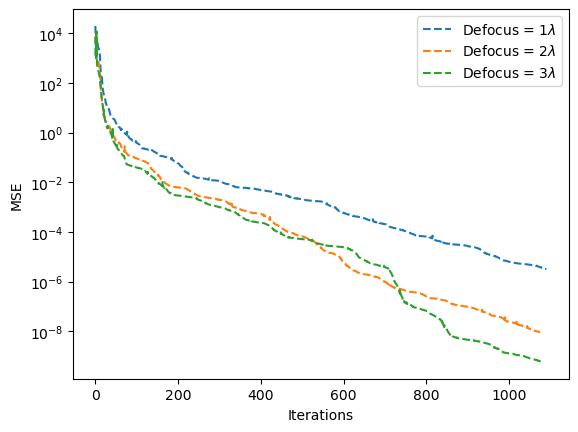

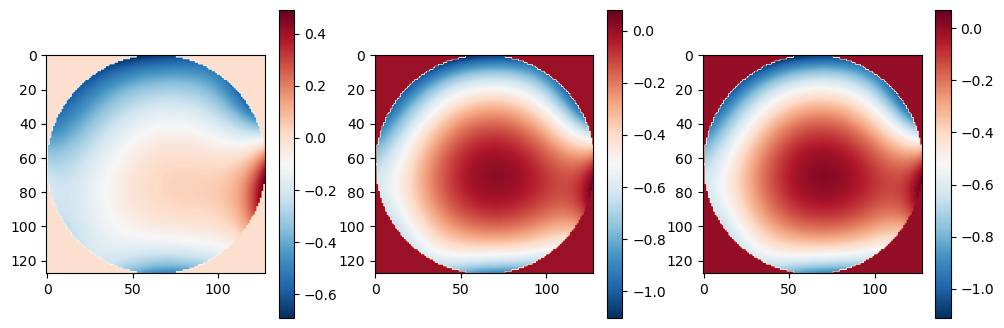

In [272]:
plt.figure()
optlist = [adpr1, adpr2, adpr3]
for i in range(1,4):
    plt.plot(optlist[i-1].cost, label=f'Defocus = {i}'+r'$\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

plt.figure(figsize=[12,4])
reslist = [results1.x, results2.x, results3.x]
for i in range(3):
    plt.subplot(1,3,i+1)
    phase_est = sum_of_2d_modes(basis_norm, reslist[i-1])
    plt.imshow(phase_est * A, cmap='RdBu_r')
    plt.colorbar()
plt.show()

# Let us next examine the Zernike coefficients
Below we plot the modal coefficients as a function of Noll Zernike index and observe that all values are nearly identical - save a single term. This happens to be the value that corresponds to defocus. Since we are already applying some amount of defocus to these data, the coefficients derived here correspond to the error in our estimation of defocus.


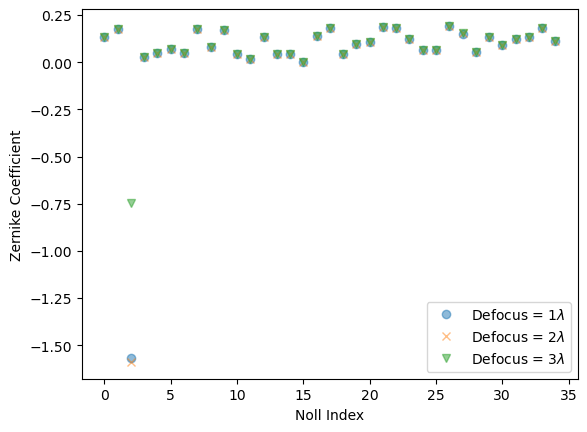

In [273]:
plt.figure()
optlist = [results1.x, results2.x, results3.x]
mstyle = ['o', 'x', 'v']
for i in range(0,3):
    plt.plot(optlist[i], label=f'Defocus = {i+1}'+r'$\lambda$', linestyle='None', marker=mstyle[i], alpha=0.5)
plt.ylabel('Zernike Coefficient')
plt.xlabel('Noll Index')
plt.legend()
plt.show()

We next need to convert this to the Hopkins defocus polynomial, the relation for which Wyant has kindly derived for us.

$$ W_{020} = 2Z_{3} - 6Z_{8} \pm \sqrt{Z_{4}^{2} + Z_{5}^{2}} $$

However this uses his own polynomial basis, so to clarify, the Zernike polynomials are
| Zernike | Name | Wyant Polynomial | Wyant to Noll Conversion Factor |
| --- | --- | --- | --- |
| $Z_{3}$ | Focus | $2\rho^{2} - 1$ | $\sqrt{3}$ |
| $Z_{8}$ | Primary Spherical | $6\rho^{4} - 6\rho^{2} + 1$ | $\sqrt{5}$ |
| $Z_{4}$ | $0^{\circ}$ Astigmatism | $\rho^{2}cos(\theta)$ | $\sqrt{6}$ |
| $Z_{5}$ | $45^{\circ}$ Astigmatism | $\rho^{2}sin(\theta)$ | $\sqrt{6}$ | 

Truly I don't know if I'm doing this step correctly


In [274]:
# def zernike_to_hopkins_defocus(coeffs):
#     Z3 = coeffs[2] / np.sqrt(3)
#     Z8 = coeffs[9] / np.sqrt(5)
#     Z4 = coeffs[3] / np.sqrt(6)
#     Z5 = coeffs[4] / np.sqrt(6)

#     s1 = 2 * Z3 - Z8 + np.sqrt(Z4**2 + Z5**2)
#     s2 = 2 * Z3 - Z8 - np.sqrt(Z4**2 + Z5**2)

#     if np.abs(s1) > np.abs(s2):
#         return s2
#     else:
#         return s1

def zernike_to_hopkins_defocus(defocus_coefficient):
    return defocus_coefficient / np.sqrt(3)

In [275]:
defocus_correction = []
for i, res in enumerate(reslist):
    defocus_correction.append(zernike_to_hopkins_defocus(res[2]))
    print('truth = ',defocus_error[i])
    print('fit = ',zernike_to_hopkins_defocus(res[2]))

truth =  0.9245364973296423
fit =  -0.9059758940715675
truth =  0.9346358739042809
fit =  -0.9169229057367783
truth =  0.48601364582569173
fit =  -0.42998071285585904


# Add the learned defocus error

In [279]:
# balance model uncertainty
adpr0 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[1], IC['image_dx'], defocus_waves=1 - defocus_correction[0], initial_phase=phase_guess)
adpr2 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[2], IC['image_dx'], defocus_waves=2 - defocus_correction[1], initial_phase=phase_guess)
adpr3 = poi.ADPhaseRetireval(A, dx_p, efl, wvl, basis_norm, error_psfs[3], IC['image_dx'], defocus_waves=3 - defocus_correction[2], initial_phase=phase_guess)

# set up the net optimizer
optlist = [adpr0, adpr1, adpr2, adpr3]
fdpr = ParallelFDPR(optlist)

In [280]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1, 'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17899D+05    |proj g|=  4.96482D+06

At iterate    1    f=  1.56856D+05    |proj g|=  7.77191D+05

At iterate    2    f=  1.43751D+05    |proj g|=  1.07453D+05

At iterate    3    f=  1.43186D+05    |proj g|=  7.63509D+04


 This problem is unconstrained.



At iterate    4    f=  1.22946D+05    |proj g|=  1.42577D+06

At iterate    5    f=  1.21340D+05    |proj g|=  1.60304D+06

At iterate    6    f=  9.91662D+04    |proj g|=  1.69310D+06

At iterate    7    f=  5.41655D+04    |proj g|=  1.16129D+06

At iterate    8    f=  2.08549D+04    |proj g|=  3.22699D+05

At iterate    9    f=  1.57266D+04    |proj g|=  7.51401D+04

At iterate   10    f=  1.49969D+04    |proj g|=  6.83780D+04

At iterate   11    f=  1.32342D+04    |proj g|=  6.44204D+04

At iterate   12    f=  8.92855D+03    |proj g|=  1.28039D+05

At iterate   13    f=  3.73437D+03    |proj g|=  4.48293D+04

At iterate   14    f=  3.32446D+03    |proj g|=  4.76236D+04

At iterate   15    f=  3.22922D+03    |proj g|=  1.74641D+04

At iterate   16    f=  3.10319D+03    |proj g|=  1.94438D+04

At iterate   17    f=  2.33993D+03    |proj g|=  6.83426D+04

At iterate   18    f=  1.83589D+03    |proj g|=  6.12713D+04

At iterate   19    f=  1.34940D+03    |proj g|=  2.12055D+04

At iter

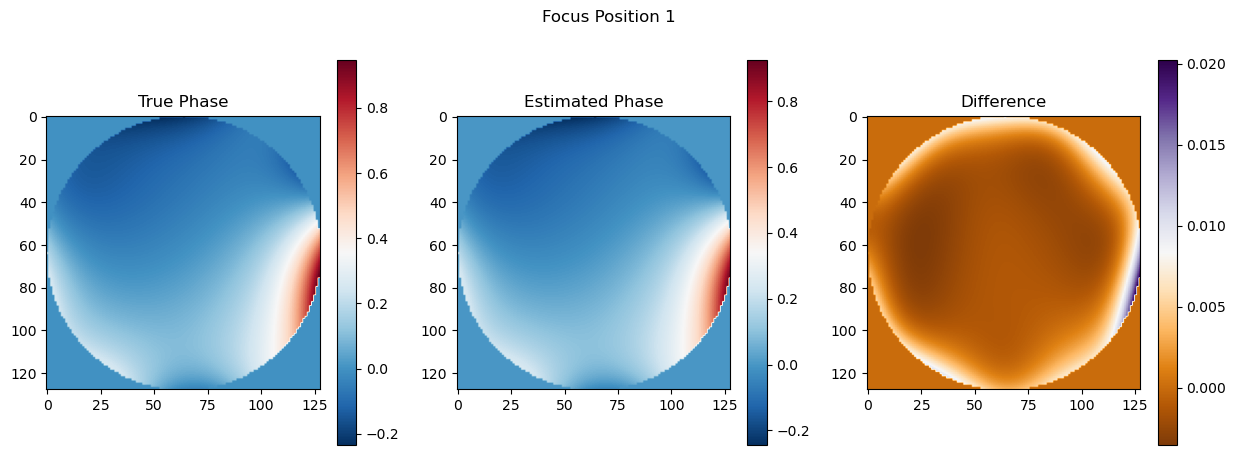

RMS nanometers difference =  3.072851313753023


In [282]:
cm = 'RdBu_r'
adpr = fdpr.optlist[0]
plt.figure(figsize=[15, 5])
plt.suptitle('Focus Position 1')
plt.subplot(131)
plt.title('True Phase')
plt.imshow(phs * A, cmap=cm)
plt.colorbar()
plt.subplot(132)
plt.title('Estimated Phase')
plt.imshow(adpr.phs * A, cmap=cm)
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
diff = (phs - adpr.phs)
diff -= np.mean(diff[A==1])
plt.imshow(diff * A, cmap='PuOr')
plt.colorbar()
plt.show()
print('RMS nanometers difference = ',np.std(diff[A==1]) * 1e3)

While we didn't converge to the same level as previous - we shrunk the 161nm RMS error down to 3nm RMS, nearly 3 orders of magnitude improved! You can imagine repeating these steps a couple of times to progressively learn the error in defocus more to further this accuracy. 

In real applications, the different PSFs may also have different positions on the focal plane. Consequently, one would also optimize the tilt modes. This is extensible to any aberration because it just acts like an offset to the phase estimation that is problem-specific.